# Linear Regression Model of Solar Output
This notebook contains a model to predict solar contributions to electrical supply from time series UV index data.



### Imports

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Read in UV Data

In [58]:
uv1 = pd.read_csv('../datasets/time_series/solar_cluster.csv')
uv2 = pd.read_csv('../datasets/time_series/solar_cluster2.csv')
uv = pd.concat([uv1,uv2],axis=0)
uv['date'] = pd.to_datetime(uv['date'],format='%Y-%m-%dT%H:%M:%S')
uv.set_index('date',inplace=True)
uv.index = pd.to_datetime(uv.index)
print(uv.shape)
uv.tail(3)

(1632, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
date,,,,,,,,,,,,,,,,,,,,,
2020-05-21 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-21 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-21 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Read in Solar Output Data

In [13]:
ts = pd.read_csv('../datasets/time_series/renewables_series.csv')
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
mwh = ts.resample('H').mean()
print(mwh.shape)
mwh.tail(3)

(18504, 5)


,solar,wind,geothermal,biomass,biogas
date,,,,,
2020-05-21 21:00:00,-3.000000,3037.583333,938.250000,347.833333,230.666667
2020-05-21 22:00:00,-3.000000,3265.083333,941.583333,341.833333,229.666667
2020-05-21 23:00:00,-3.909091,3296.090909,941.818182,338.090909,230.000000


### Merge datasets on time index

In [14]:
data = pd.merge(uv,mwh['solar'],how='left',left_index=True, right_index=True)
print(data.shape)
data.head(3)

(1632, 31)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,solar
date,,,,,,,,,,,,,,,,,,,,,
2020-03-15 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0
2020-03-15 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0
2020-03-15 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0


### EDA

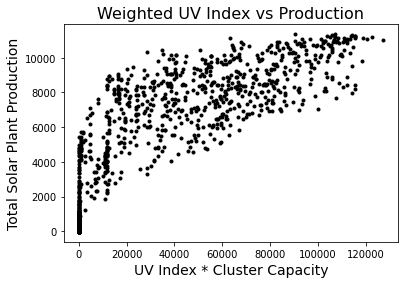

In [72]:
plt.plot(uv.sum(axis=1),data['solar'],'k.')
plt.xlabel('UV Index * Cluster Capacity',fontsize=14)
plt.ylabel('Total Solar Plant Production',fontsize=14)
plt.title('Weighted UV Index vs Production',fontsize=16);
#plt.savefig('../images/weighted-uv_vs_production.png',dpi=235,bbox_inches='tight');

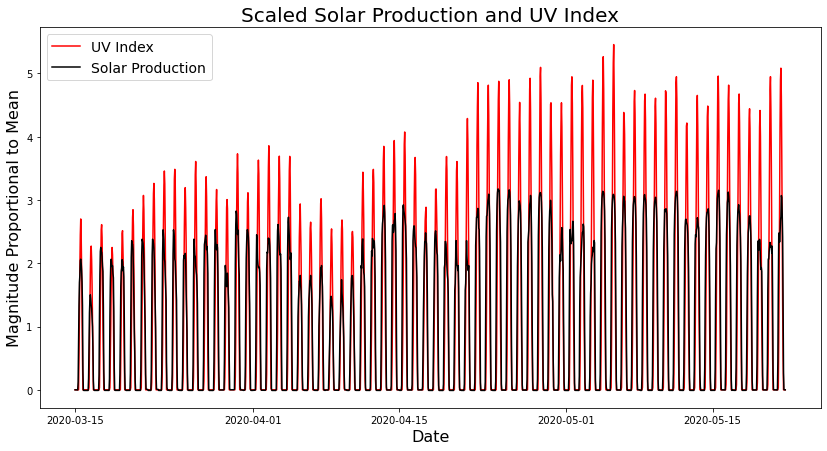

In [29]:
plt.figure(figsize=(14,7))
plt.plot(uv.index,uv.sum(axis=1)/np.mean(uv.sum(axis=1)),'r-',label='Sum UV Index')
plt.plot(uv.index,data['solar']/np.mean(data['solar']),'k-',label='Solar Production')
plt.ylabel('Magnitude Proportional to Mean',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.title('Scaled Solar Production and UV Index',fontsize=20)
plt.legend(loc='upper left',fontsize=14);

### Add dummy columns for morning, midday, afternoon, night

In [35]:
# morning = 6am-10am
data['morning'] = [1 if int(t)>6 and int(t)<=10 else 0 for t in uv.index.hour]
# midday = 10am-3pm
data['midday'] = [1 if int(t)>10 and int(t)<=15 else 0 for t in uv.index.hour]
# afternoon = 3pm-7pm
data['afternoon'] = [1 if int(t)>15 and int(t)<=19 else 0 for t in uv.index.hour]
# night = 7pm-6am
data['night'] = [1 if int(t)>19 or int(t)<=6 else 0 for t in uv.index.hour]

### Train test split

In [47]:
X = data.drop(columns='solar')
y = data['solar']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,shuffle=False)

### Fit model and generate predictions

In [48]:
lr = LinearRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

### Visualize results

RMSE = 1254.4
Training score: 0.919
Testing score: 0.915


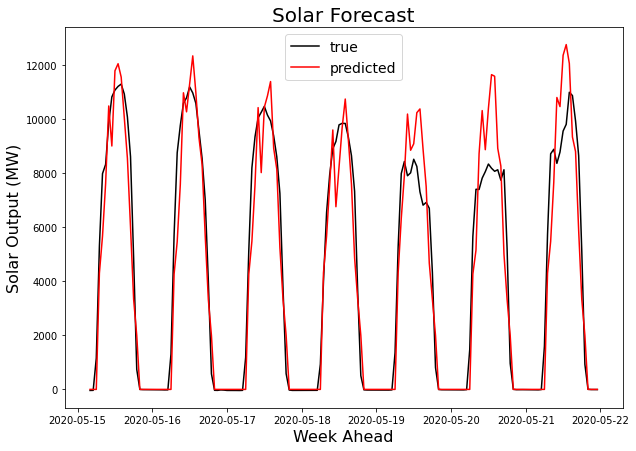

In [74]:
print(f"RMSE = {round(np.sqrt(mean_squared_error(y_test, preds)),1)}")
print(f"Training score: {round(lr.score(X_train,y_train),3)}")
print(f"Testing score: {round(lr.score(X_test,y_test),3)}")
plt.figure(figsize=(10,7))
plt.plot(y_test.index,y_test,'k-',label='true')
plt.plot(y_test.index,preds,'r-',label='predicted')
plt.legend(fontsize=14)
plt.xlabel('Week Ahead',fontsize=16)
plt.ylabel('Solar Output (MW)',fontsize=16)
plt.title('Solar Forecast',fontsize=20);
#plt.savefig('../images/solar_forecast.png',dpi=235,bbox_inches='tight');

### Write predictions to file

In [55]:
predictions = pd.DataFrame({'date':y_test.index,'solar_prediction':preds})
predictions.to_csv('../datasets/solar_prediction.csv',index=False)